## Environment Setup:
This notebook is intended to be run on Google Colab. You may complete the tasks offline, but at your own risk.

## Add dataset shortcut from your Google Account
Because of the size of the datasets, we are providing the files from Google Drive.

To access the provided data, go to [this link](https://drive.google.com/drive/folders/1_5LoxbmWDKPKi91Z_HmQn4TFoTtXnxQM?usp=sharing) and click "COMP4211_dataset->Organise->Add shortcut" to save a shortcut in your Google Drive "My Drive" folder (or any specific path in your google drive)

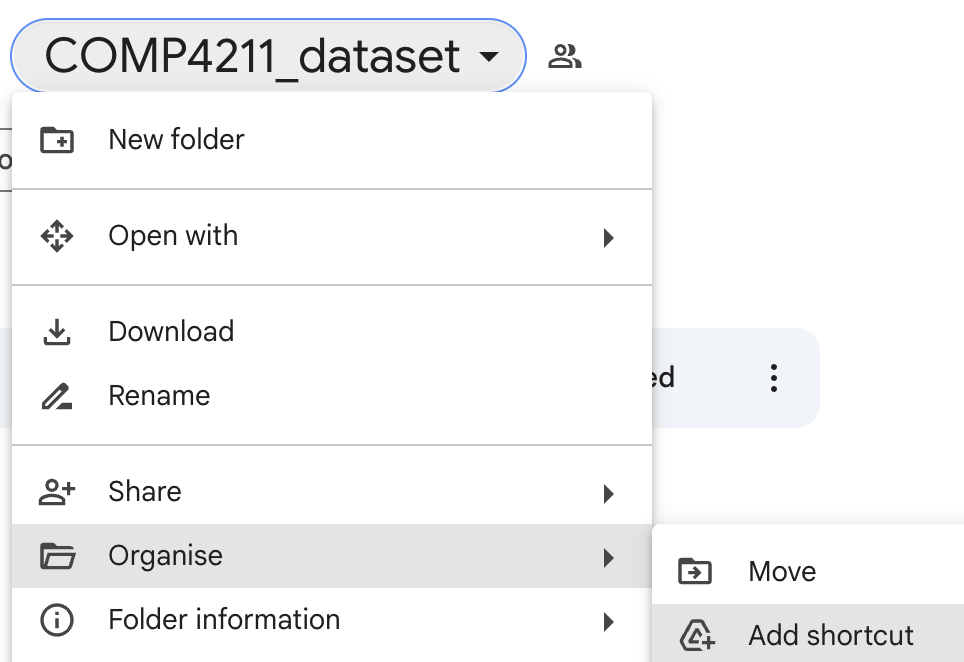

Mount the dataset by the following code (requires authorization):

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/COMP4211_dataset"
vgg_path = os.path.join(data_path, 'vgg19.npz')

pacs_zip = os.path.join(data_path, 'classify/pacs-dataset.zip')
wikiart_zip = os.path.join(data_path, 'wikiart.zip')
coco_zip = os.path.join(data_path, 'COCO.zip')

pacs_path = "classify"
wikiart_path = "wikiart"
coco_path = "COCO"


Mounted at /content/drive


To speed up the image loading, we unzip the training image datasets to the Google Colab VM rather than access it directly from Google Drive.

In [ ]:
!unzip "$wikiart_zip" > /dev/null 2>&1
!unzip "$coco_zip" > /dev/null 2>&1

(Tip: If you're only doing the second task, skip the above code to save a bit of time)

In [ ]:
# Put the PACS files in a subfolder
!mkdir -p "$pacs_path"
!unzip "$pacs_zip" -d "$pacs_path" > /dev/null 2>&1

## Preparation

This section contains imports and functions that will be used in the later tasks. Some of them are provided.

### Imports

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, accuracy_score

# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm.notebook import tqdm
import cv2
import seaborn as sns

# Other utility
import datetime
import psutil
import json
import time

# Module settings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

### Utility Functions

**Preprocessing and Deprocessing Images**: In style transfer, images often need to be adjusted before and after passing through the model. The `preprocess` function converts images from RGB (used in most image formats) to BGR (used by the model) and normalizes pixel values by subtracting a mean value. This step helps in aligning the image data with the format expected by the VGG network, which our style transfer model is based on. Conversely, the `deprocess` function reverses these adjustments, converting the image back from BGR to RGB and adding the mean pixel values, making the output image suitable for viewing.

**Loading Images**: The `get_image` function reads an image from the disk, converts it to the RGB format, and optionally resizes it. This function is crucial for preparing your dataset for training or evaluation. It ensures that all images fed into the model are consistent in size and format.

**Finding Images**: The `find_images` function takes a directory path and a file type, and finds (recursively) all files within the directory that matches the file type. This is used for obtaining the images in the WikiArt and COCO dataset, as the images are put in different folders.

In [ ]:
# Prepares an image for the model by converting RGB to BGR and subtracting the mean pixel values.
def preprocess(x):
    img = tf.reverse(x, axis=[-1])  # RGB to BGR
    img -= np.array([103.939, 116.779, 123.68])  # Subtract mean pixel value
    return img

# Converts the output of the model back to a viewable image by adding mean pixel values and converting BGR to RGB.
def deprocess(x):
    img = x + np.array([103.939, 116.779, 123.68])  # Add mean pixel value
    img = tf.reverse(img, axis=[-1])  # BGR to RGB
    img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure pixel value range is valid
    return img

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(256,256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    image = image.astype(np.float32)  # Convert to float32 for model compatibility
    return image

# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths


### Datasets

This programming assignment requires 2 types of dataset, both used for loading images on-demand:

- `ImageDataset`, a dataset class that finds and collects image files within a given directory, and loads them for training. A single sample should only include the image bitmap (preprocessed using the above functions).
- `ClassificationDataset`, a dataset class that references a given `.tsv` file for file names and labels, and loads the images from the given directory along with the class label. A single sample should include the processed image bitmap, along with its class label in one-hot encoding.

In [ ]:
# [C1]
class ImageDataset:
    def __init__(self, dir_path, batch_size=8, file_type="jpg", random_state = 4211):
        self.dir_path = dir_path
        self.file_type = file_type
        self.batch_size = batch_size
        self.seed = random_state
        self.image_paths = find_images(self.dir_path, self.file_type)
        self.ds_pointer = 0
        self.reset_pointer(self.seed)
        self.total_batches = len(self.image_paths) // self.batch_size

    def reset_pointer(self, seed=None):
        if seed is None:
            seed = self.seed
        np.random.seed(seed)
        np.random.shuffle(self.image_paths)
        self.ds_pointer = 0

    def get_batch(self):
        # Handle the case where the pointer is out of bounds
        if self.ds_pointer >= len(self.image_paths):
            self.reset_pointer()
            return self.get_batch()

        # Handle the case where the number of imaages is less than batch size
        if self.ds_pointer + self.batch_size > len(self.image_paths):
            self.reset_pointer()
            return self.get_batch()

        batch_paths = self.image_paths[self.ds_pointer:self.ds_pointer+self.batch_size]
        self.ds_pointer += self.batch_size

        batch_images = np.array([preprocess(get_image(path)) for path in batch_paths])
        return batch_images

    def __len__(self):
        return len(self.image_paths)

In [ ]:
# Load the COCO dataset
coco_dataset = ImageDataset(coco_path)
print(f"COCO dataset size: {len(coco_dataset)}")

# Load the WikiArt dataset
wikiart_dataset = ImageDataset(wikiart_path)
print(f"WikiArt dataset size: {len(wikiart_dataset)}")


COCO dataset size: 3557
WikiArt dataset size: 7492


In [ ]:
# Here's a preview of what the TSV would look like (top 10 rows):
!cat "$pacs_path/train-data.tsv" | head -n 10

pic_2524.jpg	sketch	dog
pic_888.jpg	sketch	dog
pic_1279.jpg	sketch	dog
pic_2694.jpg	sketch	dog
pic_79.jpg	sketch	dog
pic_650.jpg	sketch	dog
pic_2095.jpg	sketch	dog
pic_481.jpg	sketch	dog
pic_332.jpg	sketch	dog
pic_1417.jpg	sketch	dog


In [ ]:
# [C2]
class ClassificationDataset:
    def __init__(self, tsv_path, dir_path, batch_size=8, random_state = 4211):
        self.tsv_path = tsv_path
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.seed = random_state
        self.ds_pointer = 0
        self.data_frame = None
        self.label_classes = None
        self._process_tsv(tsv_path, dir_path)
        self.reset_pointer(self.seed)
        self.total_batches = len(self.data_frame) // self.batch_size


    # Tip: It is recommended to use this method to process the tsv data into a data table, since this will be used in both __init__() and add_data().
    def _process_tsv(self, tsv_path, dir_path):
        df = pd.read_csv(tsv_path, sep='\t', header=None, names=['filename', 'style', 'classification'])
        df['filepath'] = df['filename'].apply(lambda x: os.path.join(dir_path, x))

        # Convert classification labels to categorical and then to one-hot encoding
        df['classification'] = pd.Categorical(df['classification'])
        self.label_classes = df['classification'].cat.categories
        df = pd.concat([df, pd.get_dummies(df['classification'], prefix='class')], axis=1)
        self.data_frame = df

    def add_data(self, tsv_path, dir_path):
        new_df = pd.read_csv(tsv_path, sep='\t', header=None, names=['filename', 'style', 'classification'])
        new_df['filepath'] = new_df['filename'].apply(lambda x: os.path.join(dir_path, x))
        new_df['classification'] = pd.Categorical(new_df['classification'], categories=self.label_classes)
        new_df = pd.concat([new_df, pd.get_dummies(new_df['classification'], prefix='class')], axis=1)
        self.data_frame = pd.concat([self.data_frame, new_df], ignore_index=True)
        self.reset_pointer()

    def reset_pointer(self, seed=None):
        if seed is None:
            seed = self.seed
        np.random.seed(seed)
        self.data_frame = self.data_frame.sample(frac=1).reset_index(drop=True)
        self.ds_pointer = 0

    def get_batch(self):
        # Handle the case where the pointer is out of bounds
        if self.ds_pointer >= len(self.data_frame):
            self.reset_pointer()
            return self.get_batch()

        batch_df = self.data_frame.iloc[self.ds_pointer:self.ds_pointer + self.batch_size]
        # Handle the case where the number of imaages is less than batch size
        if len(batch_df) < self.batch_size:
            self.reset_pointer()
            return self.get_batch()

        self.ds_pointer += self.batch_size

        batch_images = np.array([preprocess(get_image(row['filepath'])) for _, row in batch_df.iterrows()])
        batch_labels = batch_df.loc[:, batch_df.columns.str.startswith('class_')].values
        return batch_images, batch_labels

    def __len__(self):
        return len(self.data_frame)

In [ ]:
# Load the PACS training dataset
pacs_train_dataset = ClassificationDataset(os.path.join(pacs_path, 'train-data.tsv'), pacs_path)
print(f"PACS training dataset size: {len(pacs_train_dataset)}")

# Load the PACS test dataset
pacs_test_dataset = ClassificationDataset(os.path.join(pacs_path, 'test-data.tsv'), pacs_path)
print(f"PACS test dataset size: {len(pacs_test_dataset)}")

PACS training dataset size: 1641
PACS test dataset size: 2723


## Part 1: Style Transfer


### Model Components

In [ ]:
class AdaIN(Layer):
    """
    Adaptive Instance Normalization (AdaIN) layer with controllable style transfer intensity.
    This layer adjusts the mean and variance of the content features to match those of the style features,
    then blends the result with the original content features based on a specified alpha value.
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.epsilon = epsilon  # Small constant to avoid division by zero.

    def call(self, inputs):
        content, style, alpha = inputs

        # Compute mean and variance for content and style features.
        meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True)
        meanS, varS = tf.nn.moments(style, [1, 2], keepdims=True)

        # Standard deviation is the square root of variance, adjusted with epsilon for numerical stability.
        sigmaC = tf.sqrt(varC + self.epsilon)
        sigmaS = tf.sqrt(varS + self.epsilon)

        # Perform AdaIN by normalizing content features and scaling them by style's standard deviation and mean.
        normalized_content = (content - meanC) / sigmaC
        stylized_content = normalized_content * sigmaS + meanS

        # Blend stylized content with original content based on alpha.
        blended_content = alpha * stylized_content + (1 - alpha) * content
        return blended_content

In [ ]:
def build_vgg19_enc(input_shape, weights_path):
    weights = np.load(weights_path)

    # [C3] Create vgg19 structure
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv1_1'),
        Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2'),
        MaxPooling2D((2, 2), strides=(2, 2), name='pool1'),

        Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1'),
        Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2'),
        MaxPooling2D((2, 2), strides=(2, 2), name='pool2'),

        Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1'),
        Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2'),
        Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3'),
        Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_4'),
        MaxPooling2D((2, 2), strides=(2, 2), name='pool3'),

        Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1'),
    ])

    # [C4] Load in weights and freeze the model
    i = 0
    for layer in model.layers:
        if 'conv' in layer.name:
            kernel = weights['arr_%d' % i]
            bias = weights['arr_%d' % (i + 1)]

            kernel = kernel.transpose([2, 3, 1, 0])
            kernel = kernel.astype(np.float32)
            bias = bias.astype(np.float32)

            layer.set_weights([kernel, bias])

            i += 2

    # Freeze the model weights to prevent updates during training
    model.trainable = False

    total_params = model.count_params()
    print("Encoder total parameters:", total_params)

    return model

def build_vgg19_relus(vgg19):
    relus = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
    features = [vgg19.get_layer(relu).output for relu in relus]
    vgg19_relus = Model(inputs=vgg19.input, outputs=features)
    vgg19_relus.trainable = False
    return vgg19_relus

# [C5]
def build_decoder(input_shape):
    decoder = Sequential([
        Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        UpSampling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),

        UpSampling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        Conv2D(3, (3, 3), padding='same'),
    ])

    total_params = decoder.count_params()
    print("Decoder total trainable parameters:", total_params)

    return decoder


def build_model(encoder, decoder, input_shape):
    content = Input(shape=input_shape, name='content')
    style = Input(shape=input_shape, name = 'style')
    alpha = Input(shape=(1,), name='alpha')

    enc_content = encoder(content)
    enc_style = encoder(style)

    adain = AdaIN()([enc_content, enc_style, alpha])

    out = decoder(adain)

    return Model(inputs=[content, style, alpha], outputs=[out, adain])


In [ ]:
def get_loss(encoder, vgg19_relus, epsilon=1e-5, style_weight=1.0):

    def loss(y_true, y_pred):
        out, adain = y_pred[0], y_pred[1]

        # Encode output and compute content_loss
        out = deprocess(out)
        out = preprocess(out)
        enc_out = encoder(out)
        content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(enc_out - adain), axis=[1, 2]))

        # Compute style loss from vgg relus
        style = y_true[1]
        style_featues = vgg19_relus(style)
        gen_features = vgg19_relus(out)
        style_layer_loss = []
        for enc_style_feat, enc_gen_feat in zip(style_featues, gen_features):
            meanS, varS = tf.nn.moments(enc_style_feat, [1, 2])
            meanG, varG = tf.nn.moments(enc_gen_feat,   [1, 2])

            sigmaS = tf.sqrt(varS + epsilon)
            sigmaG = tf.sqrt(varG + epsilon)

            l2_mean  = tf.reduce_sum(tf.square(meanG - meanS))
            l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

            style_layer_loss.append(l2_mean + l2_sigma)

        style_loss = tf.reduce_sum(style_layer_loss)

        # Compute the total loss
        weighted_style_loss = style_weight * style_loss
        total_loss = content_loss + weighted_style_loss
        return total_loss, content_loss, weighted_style_loss

    return loss

### Training Routine

In [ ]:
# [C6]
def part1_train(model, content_ds, style_ds, loss_fn, n_epochs = 10, save_interval = 10, save_path=None, load_path=None, start_epoch=1, loss_file_path=None):
    # Initialize the Optimizer
    optimizer = Adam(learning_rate=1e-4, decay=5e-5)

    # Calculate the number of batches per epoch
    n_batches = content_ds.total_batches

    # Initialize other things
    process = psutil.Process(os.getpid())
    alpha = 1.0

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Function to append loss to an external file
    def append_loss_to_file(epoch, total_loss, content_loss, style_loss, file_path):
        if isinstance(total_loss, tf.Tensor):
            total_loss = total_loss.numpy().item()
            content_loss = content_loss.numpy().item()
            style_loss = style_loss.numpy().item()

        # Check if the file exists and is not empty
        try:
            with open(file_path, 'r') as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            data = []

        # Append the new loss
        data.append({'epoch': epoch, 'total_loss': total_loss, 'content_loss': content_loss, 'style_loss': style_loss})

        # Write the updated loss data back to the file
        with open(file_path, 'w') as file:
            json.dump(data, file)

    # Run for n epochs
    for e in range(start_epoch, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        content_ds.reset_pointer()
        style_ds.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"total": 0.0, "content": 0.0, "style": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            content_images = content_ds.get_batch()
            style_images = style_ds.get_batch()

            # Execute Batch Training
            # Tip: Use tf.GradientTape() when computing the loss, to obtain the gradient.
            with tf.GradientTape() as tape:
                # Pass the images to the model
                outputs = model([content_images, style_images, alpha])

                # Compute the loss
                loss_values = loss_fn([content_images, style_images], outputs)
                total_loss = loss_values[0]

                # Obtain gradients and apply them
                gradients = tape.gradient(total_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update Loss Metrics
            for i, key in enumerate(losses.keys()):
                losses[key] += loss_values[i] / n_batches

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # Average loss for this epoch
        avg_total_epoch_loss = losses['total']
        avg_content_epoch_loss = losses['content']
        avg_style_epoch_loss = losses['style']
        if loss_file_path:
            append_loss_to_file(e, avg_total_epoch_loss, avg_content_epoch_loss, avg_style_epoch_loss, loss_file_path)

        # In case the session ends before the training is done, perform a save on the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)

### Model setup

In [ ]:
def part1_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 8 #16 # Recommended according to the Google Colab T4 GPU

    content_ds = ImageDataset(coco_path, batch_size=BATCH_SIZE)
    style_ds = ImageDataset(wikiart_path, batch_size=BATCH_SIZE)

    return content_ds, style_ds

def part1_setup():
    #####
    # MODIFY SETTINGS HERE
    #####
    STYLE_WEIGHT = 2.0
    EPSILON = 1e-5

    INPUT_SHAPE = (None, None, 3) # We accept any image size

    # Build model
    vgg19 = build_vgg19_enc(INPUT_SHAPE, vgg_path)  # encoder
    decoder = build_decoder(vgg19.output.shape[1:])  # input shape == encoder output shape
    model = build_model(vgg19, decoder, INPUT_SHAPE)

    # Get loss
    vgg19_relus = build_vgg19_relus(vgg19)
    loss = get_loss(vgg19, vgg19_relus, epsilon=EPSILON, style_weight=STYLE_WEIGHT)

    return model, loss

In [ ]:
content_ds, style_ds = part1_prepare_datasets()

In [ ]:
model, loss = part1_setup()

Encoder total parameters: 3505728
Decoder total trainable parameters: 3505219


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 content (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 style (InputLayer)          [(None, None, None, 3)]      0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, None, 512)      3505728   ['content[0][0]',             
                                                                     'style[0][0]']               
                                                                                                  
 alpha (InputLayer)          [(None, 1)]                  0         []                        

We can now start the training:

In [ ]:
part1_bs_8_path = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/part1/part1_bs_8.h5"
part1_bs_16_path = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/part1/part1_bs_16.h5"

part1_bs_8_loss_file_path = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/part1/part1_bs_8_loss_records.json"
part1_bs_16_loss_file_path = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/part1/part1_bs_16_loss_records.json"


In [ ]:
#####
# We recommend you to save on your mounted Google Drive folder,
# otherwise it may get lost after the Colab session terminated
#####
PART1_SAVE_PATH = part1_bs_8_path
PART1_LOSS_PATH = part1_bs_8_loss_file_path

part1_training_time=0
start = time.time()
#part1_train(model, content_ds, style_ds, loss, n_epochs=15, save_path=PART1_SAVE_PATH, save_interval=1, loss_file_path=PART1_LOSS_PATH)
part1_training_time = time.time() - start
print(f"Total training time: {part1_training_time}")

Total training time: 5.245208740234375e-05


part1_bs_8 train time: 9816.137740373611

In [ ]:
def retrieve_epoch_from_file(file_path):
    # Load loss values from the file
    with open(file_path, 'r') as file:
        loss_records = json.load(file)
    epoch_trained = len(loss_records)
    return epoch_trained
epoch_trained = retrieve_epoch_from_file(PART1_LOSS_PATH)
print(epoch_trained)

15


In [ ]:
# To continue to train the saved weights, do this:
PART1_LOAD_PATH = PART1_SAVE_PATH

#part1_train(model, content_ds, style_ds, loss, n_epochs=15, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH, save_interval=1, start_epoch=epoch_trained+1, loss_file_path=PART1_LOSS_PATH)

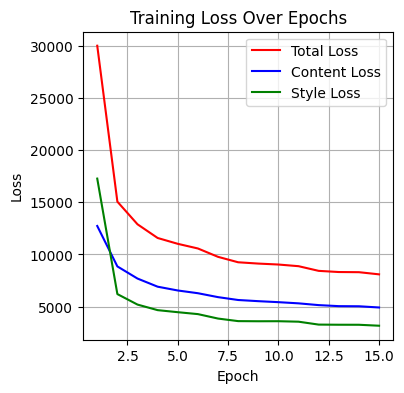

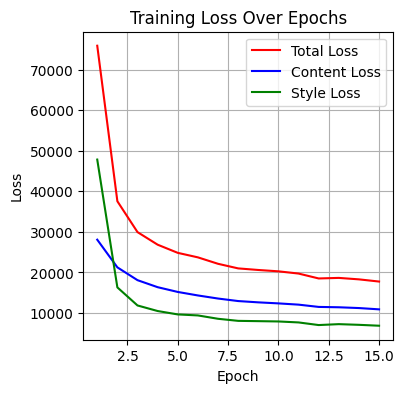

In [ ]:
def part1_plot_loss_from_file(file_path):
    # Load loss values from the file
    with open(file_path, 'r') as file:
        loss_records = json.load(file)

    # Extract epochs and loss values
    epochs = [record['epoch'] for record in loss_records]
    total_losses = [record['total_loss'] for record in loss_records]
    content_losses = [record['content_loss'] for record in loss_records]
    style_losses = [record['style_loss'] for record in loss_records]

    # Plotting
    plt.figure(figsize=(4, 4))
    plt.plot(epochs, total_losses, label='Total Loss', color='red')#, marker='o', linestyle='-')
    plt.plot(epochs, content_losses, label='Content Loss', color='blue')#, marker='x', linestyle='--')
    plt.plot(epochs, style_losses, label='Style Loss', color='green')#, marker='+', linestyle=':')

    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

part1_plot_loss_from_file(part1_bs_8_loss_file_path)
part1_plot_loss_from_file(part1_bs_16_loss_file_path)

Note: Due to the limited computing time available in Colab, it may be a good idea to divide the training into different sessions, by saving and loading the model weights in your Google Drive.  

Do not save the weights outside the drive or they will be deleted after the session ends!

### Inference

In [ ]:
# [C7]
def part1_inference(model_path, content_path, style_path, alpha):
  model = load_model(model_path, custom_objects={'AdaIN': AdaIN})

  # Get content image
  content_image = preprocess(get_image(content_path, resize=False))
  content_image = np.expand_dims(content_image, axis=0)

  # Get style image
  style_image = preprocess(get_image(style_path, resize=False))
  style_image = np.expand_dims(style_image, axis=0)

  # Set alpha Value
  alpha_tensor = tf.constant(alpha, shape=(1,))

  # Do inference
  generated_image = model.predict([content_image, style_image, alpha_tensor])[0]
  generated_image = np.squeeze(generated_image, axis=0)
  generated_image = deprocess(generated_image)

  # Convert output array to image
  # img = array_to_img(y)
  img = array_to_img(generated_image)

  # Display the image in the Notebook
  display(img)

1/1 [==============================] - 12s 12s/step


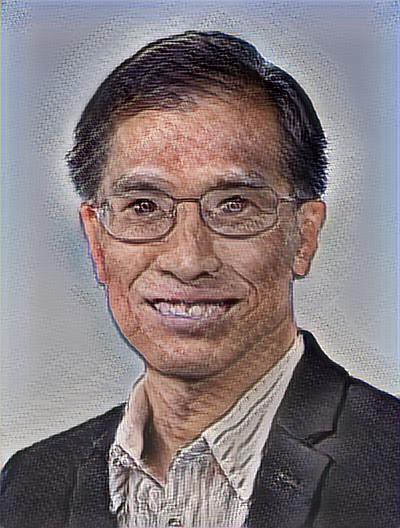

In [ ]:
#####
# MODIFY SETTINGS HERE
#####
ALPHA = 0.75
MODEL_PATH = PART1_SAVE_PATH
# Here below is a sample, please change to your own path
CONTENT_PATH = os.path.join(data_path, 'HKUST/dyyeung.jpg')
# Here below is a sample, please change to your own path
STYLE_PATH = os.path.join(wikiart_path, 'Analytical_Cubism/juan-gris_portrait-of-maurice-raynal-1911.jpg')

part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

1/1 [==============================] - 11s 11s/step


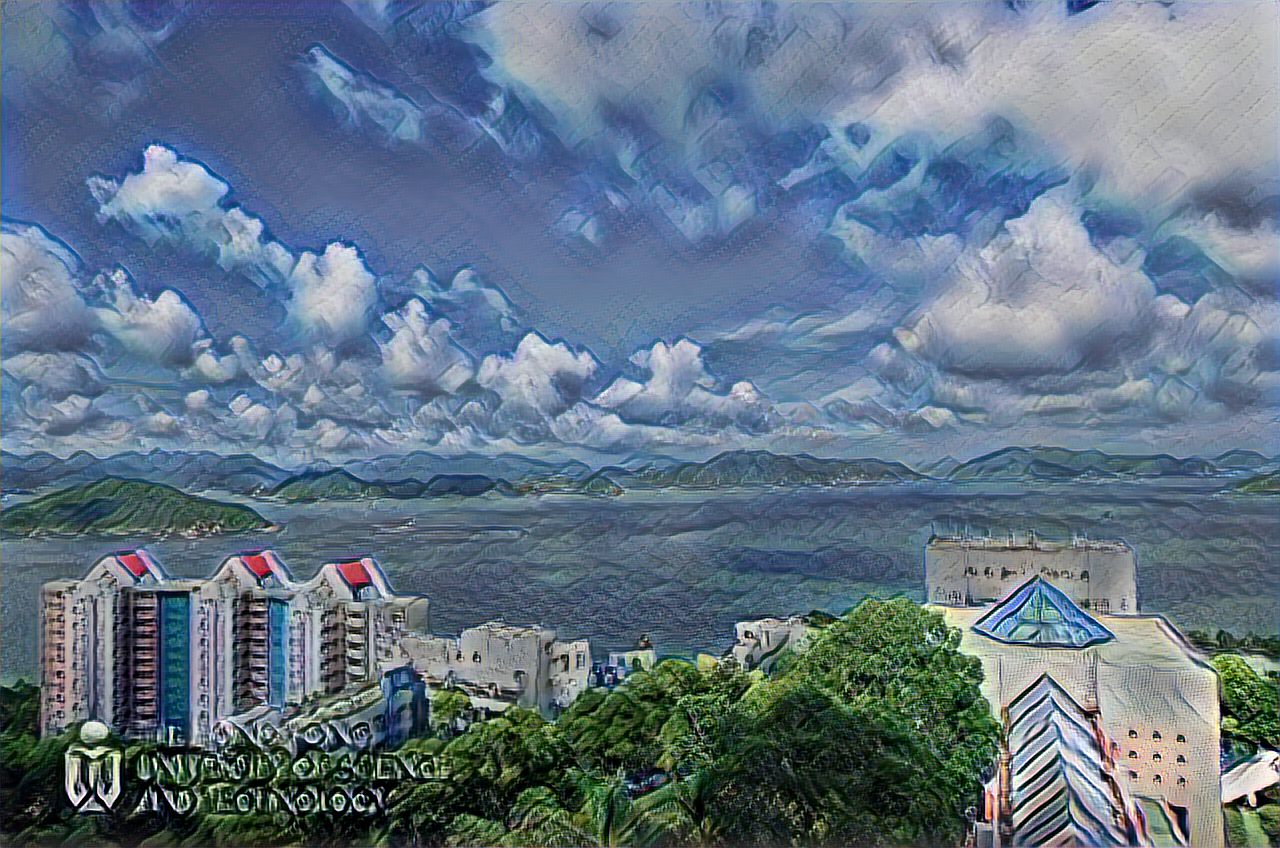

In [ ]:
# Another sample, please change and test on your own
ALPHA=0.75
CONTENT_PATH = os.path.join(data_path, 'HKUST/7.jpeg')
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = os.path.join(data_path, 'Extra_styles/the-starry-night.jpg')
part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

In [ ]:
def part1_inference_all(model_path, content_dir, style_dir, alpha, resize=True):
    model = load_model(model_path, custom_objects={'AdaIN': AdaIN})

    content_images = [os.path.join(content_dir, f) for f in os.listdir(content_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    style_images = [os.path.join(style_dir, f) for f in os.listdir(style_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    n_content = len(content_images)
    n_style = len(style_images)
    alpha_tensor = tf.constant(alpha, shape=(1,))

    fig, axs = plt.subplots(n_content, n_style + 1, figsize=(3*n_style, 3*n_content))

    for i, content_path in enumerate(content_images):
        content_image = np.expand_dims(preprocess(get_image(content_path, resize=resize)), axis=0)
        axs[i, 0].imshow(mpimg.imread(content_path))
        axs[i, 0].set_title("Content\n" + os.path.basename(content_path))
        axs[i, 0].axis('off')

        for j, style_path in enumerate(style_images):
            style_image = np.expand_dims(preprocess(get_image(style_path, resize=resize)), axis=0)
            generated_image = model.predict([content_image, style_image, alpha_tensor])[0]
            generated_image = np.squeeze(generated_image, axis=0)
            generated_image = deprocess(generated_image)
            generated_image = array_to_img(generated_image)

            if i == 0:  # Set style image title at the top
                axs[0, j + 1].set_title("Style\n" + os.path.basename(style_path))
            axs[i, j + 1].imshow(generated_image)
            axs[i, j + 1].axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 20ms/step


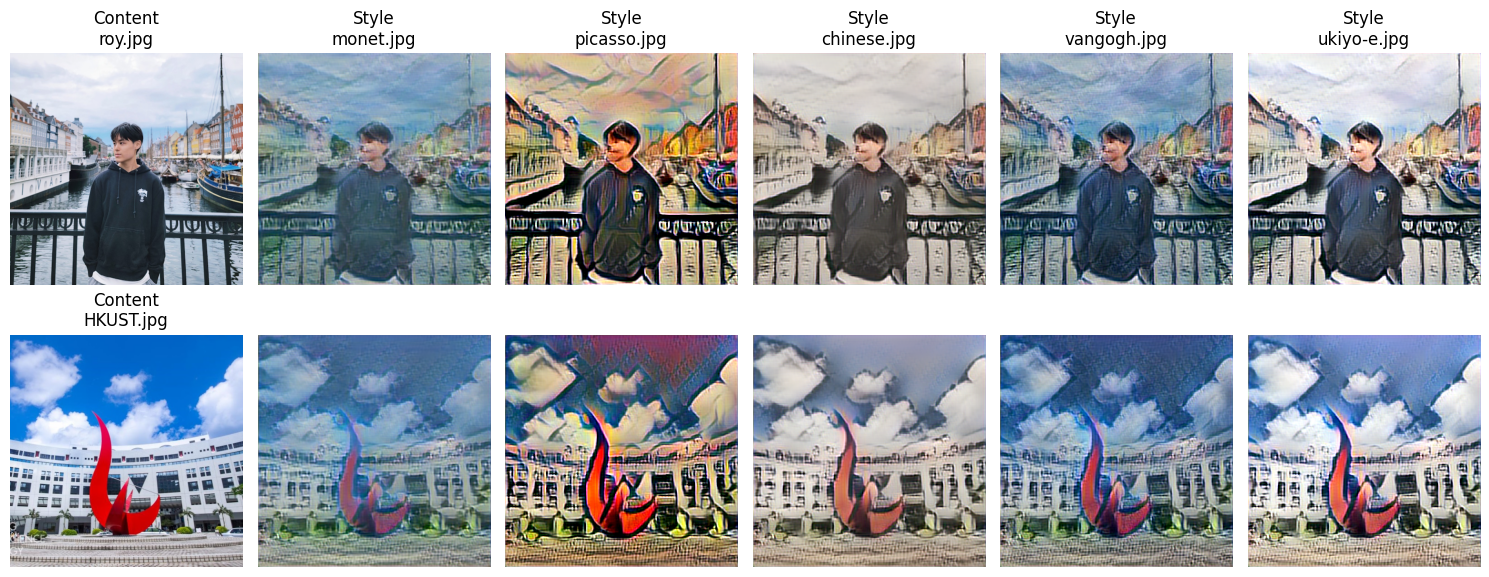

In [ ]:
ALPHA=0.75
CONTENT_PATH = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/images"
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/styles"
part1_inference_all(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

## Part 2: Classification Task

The second part of this assignment is a Classification Task, but with an unideal training dataset.

This task uses the PACS dataset (an image dataset with images of different categories and in different styles), but modified to have an abnormal distribution between styles and categories.

### Analyzing the dataset

Before we start the classification task, let's load and obtain some basic info about our training dataset.

In [ ]:
def part2_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    TEST_DS_PATH = os.path.join(pacs_path, "test-files/")
    TEST_TSV_PATH = os.path.join(pacs_path, "test-data.tsv")

    train_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    test_ds = ClassificationDataset(TEST_TSV_PATH, TEST_DS_PATH, batch_size = BATCH_SIZE)

    return train_ds, test_ds

train_ds, test_ds = part2_prepare_datasets()

Find out the distribution of images in diferent styles and categories:

<ipython-input-33-80a9066a89aa>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='counts', y='style_classification', data=tally, palette='viridis')


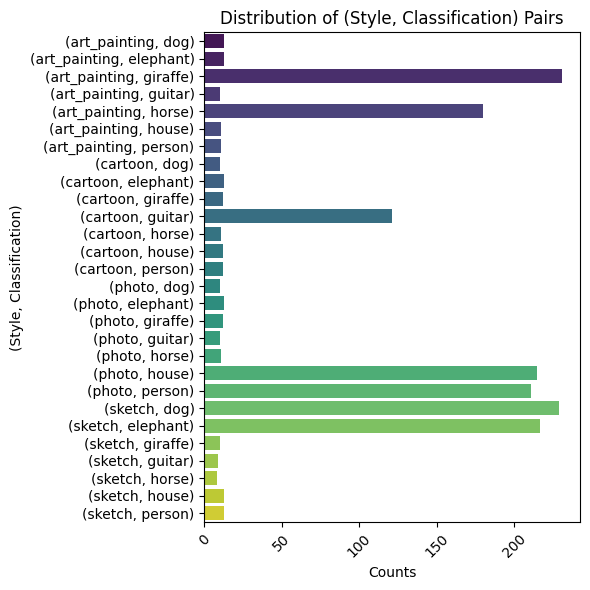

In [ ]:
# [C8]
def part2_tally_samples(dataset):
    tally = dataset.data_frame.groupby(['style', 'classification']).size().reset_index(name='counts')

    # Create a new column 'style_classification' for plotting
    tally['style_classification'] = tally.apply(lambda x: f"({x['style']}, {x['classification']})", axis=1)

    plt.figure(figsize=(6, 6))
    sns.barplot(x='counts', y='style_classification', data=tally, palette='viridis')

    plt.title('Distribution of (Style, Classification) Pairs')
    plt.xlabel('Counts')
    plt.ylabel('(Style, Classification)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

part2_tally_samples(train_ds)

Compare this to the test dataset:

<ipython-input-33-80a9066a89aa>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='counts', y='style_classification', data=tally, palette='viridis')


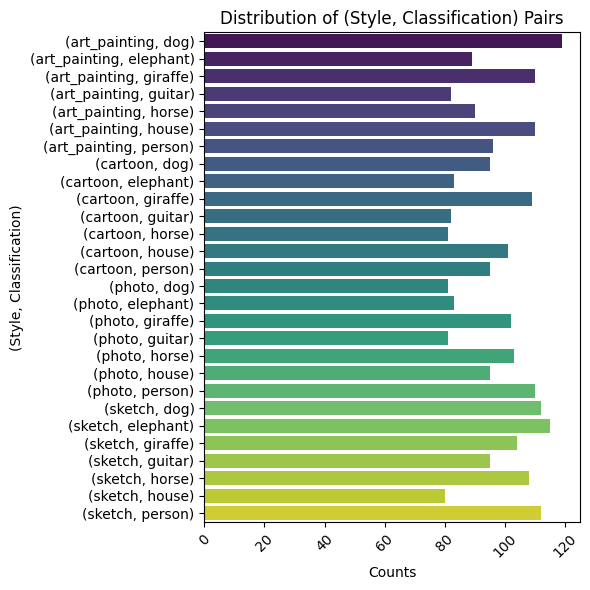

In [ ]:
part2_tally_samples(test_ds)

### Main Implementation

The architecture of the classification model is also a VGG19 model, adapted for multiclass classification.

In [ ]:
# [C9]
def build_vgg19_classifier(input_shape, num_class):
    # Create vgg19 structure
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv1_1'),
        Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2'),
        MaxPooling2D((2, 2), strides=(2, 2), name='pool1'),

        Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1'),
        Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2'),
        MaxPooling2D((2, 2), strides=(2, 2), name='pool2'),

        Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1'),
        Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2'),
        Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3'),
        Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_4'),
        MaxPooling2D((2, 2), strides=(2, 2), name='pool3'),

        Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1'),

        GlobalAveragePooling2D(name='global_pool'),
        Dense(1024, activation='relu', name='dense1'),
        Dense(1024, activation='relu', name='dense2'),
        Dense(512, activation='relu', name='dense3'),
        Dense(num_class, activation='softmax', name='dense4'),
    ])

    total_params = model.count_params()
    print("Classifier VGG19 total trainable parameters:", total_params)

    return model

In [ ]:
# [This part is not graded but is required for successful completion of other tasks]
def part2_setup(LOAD_PATH = None):
    INPUT_SHAPE = (None, None, 3)

    # Build model
    model = build_vgg19_classifier(INPUT_SHAPE, len(train_ds.label_classes))

    # Get Loss
    loss_fn = CategoricalCrossentropy()

    if LOAD_PATH:
        model.load_weights(LOAD_PATH)

    return model, loss_fn

model2, loss2 = part2_setup()

Classifier VGG19 total trainable parameters: 5609031


In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, None, None, 64)    1792      
                                                                 
 conv1_2 (Conv2D)            (None, None, None, 64)    36928     
                                                                 
 pool1 (MaxPooling2D)        (None, None, None, 64)    0         
                                                                 
 conv2_1 (Conv2D)            (None, None, None, 128)   73856     
                                                                 
 conv2_2 (Conv2D)            (None, None, None, 128)   147584    
                                                                 
 pool2 (MaxPooling2D)        (None, None, None, 128)   0         
                                                                 
 conv3_1 (Conv2D)            (None, None, None, 256)  

### Training the model with the given dataset

In [ ]:
# [C10]
def part2_train(model, dataset, loss_fn, n_epochs = 100, save_interval = 10, save_path=None, load_path=None, start_epoch=1, loss_file_path=None):
    # Initialize the Optimizer
    optimizer = Adam(learning_rate=1e-4, decay=5e-5)

    # Calculate the number of batches per epoch
    n_batches = dataset.total_batches #len(dataset) // dataset.batch_size

    # Initialize other things
    process = psutil.Process(os.getpid())

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Function to append loss to an external file
    def append_loss_to_file(epoch, loss, file_path):
        if isinstance(loss, tf.Tensor):
            loss = loss.numpy().item()
        # Check if the file exists and is not empty
        try:
            with open(file_path, 'r') as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            data = []

        # Append the new loss
        data.append({'epoch': epoch, 'loss': loss})

        # Write the updated loss data back to the file
        with open(file_path, 'w') as file:
            json.dump(data, file)

    # Run for n epochs
    for e in range(start_epoch, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        dataset.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"cross-entropy": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            batch_images, batch_labels = dataset.get_batch()
            batch_images = batch_images.astype(np.float32)
            batch_labels = batch_labels.astype(np.float32)

            # Execute Batch Training
            with tf.GradientTape() as tape:
                # Pass the images to the model
                outputs = model(batch_images)

                # Compute the loss
                loss_value = loss_fn(batch_labels, outputs)

                # Obtain gradients and apply them
                gradients = tape.gradient(loss_value, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update Loss Metrics
            losses['cross-entropy'] += loss_value / n_batches

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # Average loss for this epoch
        avg_epoch_loss = losses['cross-entropy']
        if loss_file_path:
            append_loss_to_file(e, avg_epoch_loss, loss_file_path)

        # In case the session ends before the training is done, perform save the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)

In [ ]:
# Train the model
PART2_SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/part2/classify.h5" # [Change to your own path]
part2_loss_file_path = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/part2/part2_loss_records.json"
# [Call your train function here]
#part2_train(model2, train_ds, loss2, n_epochs=100, save_path=PART2_SAVE_PATH, save_interval=5, loss_file_path=part2_loss_file_path)

In [ ]:
epoch_trained = retrieve_epoch_from_file(part2_loss_file_path)
print(epoch_trained)

100


In [ ]:
PART2_LOAD_PATH = PART2_SAVE_PATH #'/content/drive/My Drive/Colab Notebooks/comp4211/pa2/part2/classify.h5' # Change to your own path

#part2_train(model2, train_ds, loss2, n_epochs=100, save_path=PART2_SAVE_PATH, load_path=PART2_LOAD_PATH, save_interval=5, start_epoch=epoch_trained+1, loss_file_path=part2_loss_file_path)

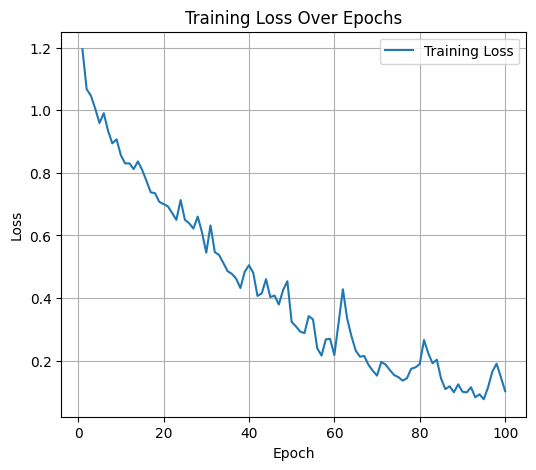

In [ ]:
def part2_plot_loss_from_file(file_path):
    # Load loss values from the file
    with open(file_path, 'r') as file:
        loss_records = json.load(file)

    # Extract epochs and loss values
    epochs = [record['epoch'] for record in loss_records]
    losses = [record['loss'] for record in loss_records]

    plt.figure(figsize=(6, 5))
    plt.plot(epochs, losses, label='Training Loss')

    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

part2_plot_loss_from_file(part2_loss_file_path)

### Testing

We can now test our first classifier model with the test dataset (maybe train dataset too, to make sure the training went properly).

Calculate the accuracy of the model, as well as the confusion matrix to for a clearer idea on the model's performance:

In [ ]:
# [C11]
def part2_evaluate(model_path, dataset):
    # Load the model from the specified path
    model = load_model(model_path)

    all_true_labels = []
    all_pred_labels = []

    # Calculate the total number of batches
    total_batches = dataset.total_batches

    # Reset dataset
    dataset.reset_pointer()

    # Iterate over all batches in the dataset
    for _ in range(total_batches):
        batch_images, batch_labels = dataset.get_batch()

        # Predict labels for the current batch
        preds = model.predict(batch_images, verbose=0)

        # Convert predictions from one-hot encoded vectors to label indices
        pred_labels = np.argmax(preds, axis=-1)
        true_labels = np.argmax(batch_labels, axis=-1)

        # Accumulate the true and predicted labels
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)

    # Calculate overall accuracy
    accuracy = accuracy_score(all_true_labels, all_pred_labels)

    # Calculate the confusion matrix
    cm = confusion_matrix(all_true_labels, all_pred_labels)

    return accuracy, cm, all_true_labels, all_pred_labels

train_accuracy, train_cm, train_all_true_labels, train_all_pred_labels = part2_evaluate(PART2_SAVE_PATH, train_ds)
test_accuracy, test_cm, test_all_true_labels, test_all_pred_labels = part2_evaluate(PART2_SAVE_PATH, test_ds)

In [ ]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9450
Test Accuracy: 0.4665


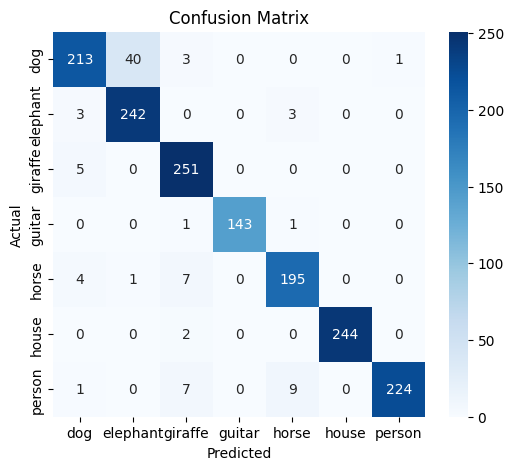

In [ ]:
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xticks(rotation=0)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(train_cm, train_ds.label_classes.tolist())

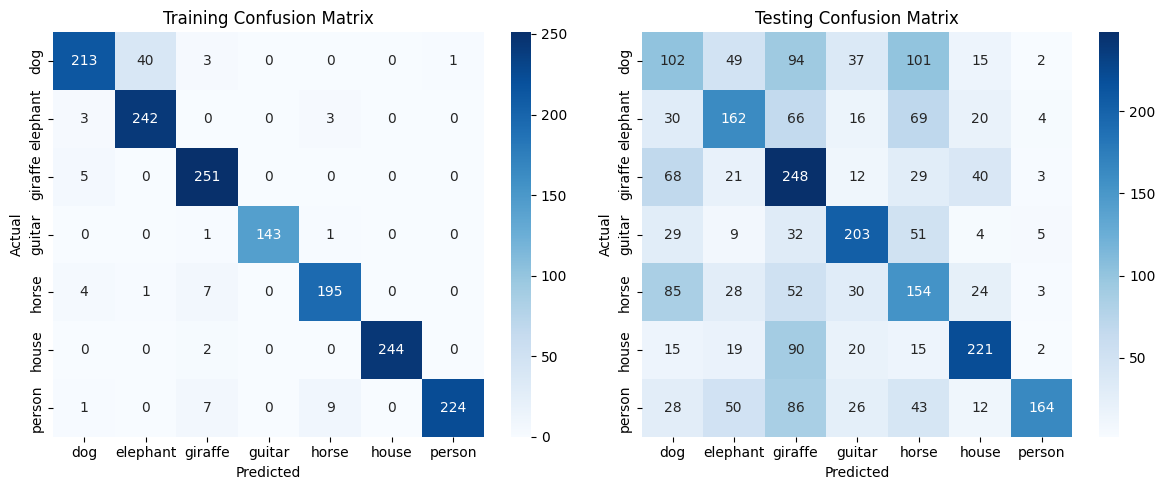

In [ ]:
def plot_confusion_matrices(train_cm, test_cm, class_names):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training confusion matrix
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax[0])
    ax[0].set_title('Training Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    plt.setp(ax[0].get_xticklabels(), rotation=0)

    # Plot testing confusion matrix
    sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax[1])
    ax[1].set_title('Testing Confusion Matrix')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')
    plt.setp(ax[1].get_xticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(train_cm, test_cm, train_ds.label_classes.tolist())

In [ ]:
def showcase_mislabeled_images(all_true_labels, all_pred_labels, dataset, num_rows=1):
    class_names = dataset.label_classes.tolist()

    seed = dataset.seed
    if seed is not None:
        np.random.seed(seed)

    # Find indices of mislabeled samples
    mislabeled_indices = [i for i, (true, pred) in enumerate(zip(all_true_labels, all_pred_labels)) if true != pred]

    # Determine the total number of samples to showcase
    num_samples = min(len(mislabeled_indices), num_rows * 7)

    # Select a random subset of mislabeled samples to display without replacement
    if num_samples > 0:
        showcase_indices = np.random.choice(mislabeled_indices, size=num_samples, replace=False)
    else:
        showcase_indices = []

    # Calculate the number of columns (up to 5 per row)
    num_cols = min(7, num_samples)

    # Setup plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1.5, num_rows * 1.5), squeeze=False)

    for i, index in enumerate(showcase_indices):
        row = i // num_cols
        col = i % num_cols

        # Retrieve the image file path and load the image
        img_path = dataset.data_frame.iloc[index]['filepath']
        image = mpimg.imread(img_path)

        # Get true and predicted labels for the image
        true_label = class_names[all_true_labels[index]]
        pred_label = class_names[all_pred_labels[index]]

        # Plot the image with annotations
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=10)

    # Hide any unused subplots
    for i in range(num_samples, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

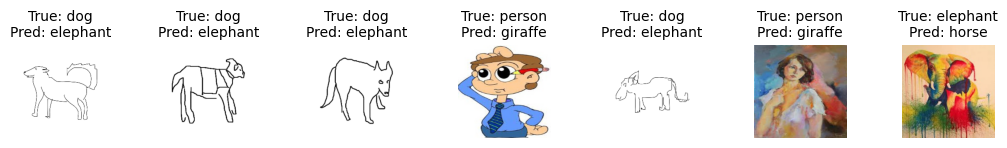

In [ ]:
showcase_mislabeled_images(train_all_true_labels, train_all_pred_labels, train_ds, num_rows=1)

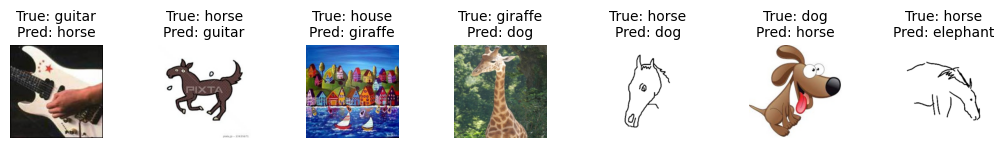

In [ ]:
showcase_mislabeled_images(test_all_true_labels, test_all_pred_labels, test_ds, num_rows=1)

### Data Augmentation with Style Transfer

In [ ]:
# [C12]
def part2_transfer(model, dataset, content_idx, style_idx, alpha):
    # Load content and style images
    content_image = preprocess(get_image(dataset.data_frame.iloc[content_idx]['filepath']))
    style_image = preprocess(get_image(dataset.data_frame.iloc[style_idx]['filepath']))

    # Expand dimensions to add batch dimension
    content_image = np.expand_dims(content_image, axis=0)
    style_image = np.expand_dims(style_image, axis=0)

    # Generate the styled image
    alpha_tensor = tf.constant(alpha, shape=(1,))

    generated_image = model.predict([content_image, style_image, alpha_tensor], verbose=0)[0]
    generated_image = np.squeeze(generated_image, axis=0)
    generated_image = deprocess(generated_image)

    # Convert output array to image
    img = array_to_img(generated_image)

    # Instead of displaying the image, return it to be saved:
    return img

In [ ]:
# [C12]
def part2_augment(part1_load_path, dataset, output_tsv, output_dir, samples_per_pair = 50, alpha = ALPHA, random_state = 4211):
    # We don't want to reload the model for every single sample,
    # so we load one here and pass it to the transfer function:
    model = load_model(part1_load_path, custom_objects={'AdaIN': AdaIN})

    # Get label and style samples to transfer from
    # These are expected to be in the form of
    # { "(label/style name)": [(list of indices in the dataset that corresponds to the label/style)], ... }
    # Tip: If you can have a pandas Dataframe from the dataset, you can use groupby(...).indices here.
    labeldict = dataset.data_frame.groupby('classification').indices
    styledict = dataset.data_frame.groupby('style').indices

    # Generate random samples
    rng = np.random.default_rng(random_state)
    derived_tsv = "" # For usage in ClassificationDataset
    pair_set = set() # To prevent generating duplicates
    for label, label_idxs in labeldict.items():
        for style, style_idxs in styledict.items():
            for _ in range(samples_per_pair):
                pair = None
                while not pair or pair in pair_set:
                    pair = rng.choice(label_idxs), rng.choice(style_idxs)
                pair_set.add(pair)

                # Generate 1 sample
                img = part2_transfer(model, dataset, pair[0], pair[1], alpha)

                # Make up a name for the same sample. Don't repeat the names!
                derived_name = f"{label}_{style}_{pair[0]}_{pair[1]}.jpg"
                # Add an entry to the TSV file. Follow the format of "train-data.tsv" and "test-data.tsv"!
                derived_entry = f"{derived_name}\t{style}\t{label}\n"

                # Save the image in the given folder
                img.save(os.path.join(output_dir, derived_name))
                # Add entry to the TSV to be written
                derived_tsv += derived_entry

    # Write the entries into the given file name
    with open(output_tsv, "w") as f:
        f.write(derived_tsv)


In [ ]:
PART1_MODEL_PATH = PART1_SAVE_PATH #os.path.join(data_path, 'saved.h5') # [Change to your part_1 saved weight]
ALPHA = 0.75

OUTPUT_TSV = "classify/derived-data.tsv"
OUTPUT_DIR = "classify/derived-files"

# Before running the augmentation, it is a good idea to prepare an empty directory for the generated outputs:
def part2_cleanup_augments(output_dir):
    !rm -rf "$output_dir"
    !mkdir -p "$output_dir"

In [ ]:
!cat "$OUTPUT_TSV"

In [ ]:
# Generate the dataset:
part2_cleanup_augments(OUTPUT_DIR)
part2_augment(PART1_MODEL_PATH, train_ds, OUTPUT_TSV, OUTPUT_DIR, samples_per_pair = 100, alpha = ALPHA, random_state = 4211)

### Training the model with an augmented dataset

After generating the images we can produce a new, augmented dataset for retraining. We would like to add the data to the existing train dataset, in order to have a more balanced distribution between different styles and categories.

In [ ]:
def part2_prepare_aug_dataset():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 16 #64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    DERIVED_DS_PATH = os.path.join(pacs_path, "derived-files/")
    DERIVED_TSV_PATH = os.path.join(pacs_path, "derived-data.tsv")

    train2_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    train2_ds.add_data(DERIVED_TSV_PATH, DERIVED_DS_PATH)

    return train2_ds

train2_ds = part2_prepare_aug_dataset()

We can confirm the augmentation by looking at its distribution:

<ipython-input-33-80a9066a89aa>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='counts', y='style_classification', data=tally, palette='viridis')


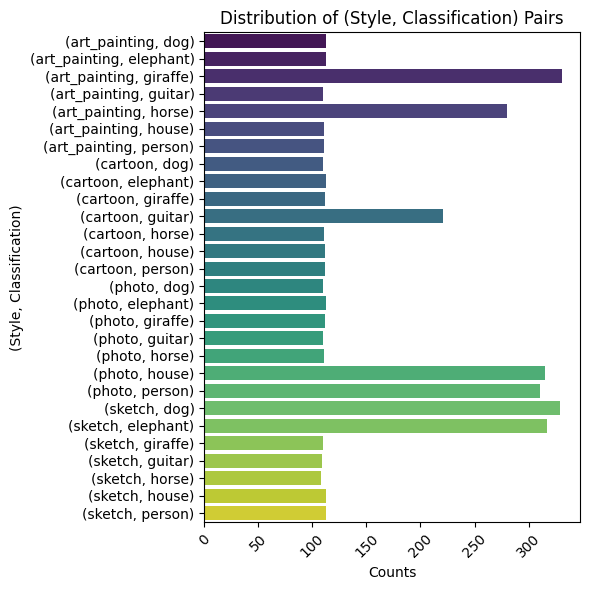

In [ ]:
part2_tally_samples(train2_ds)

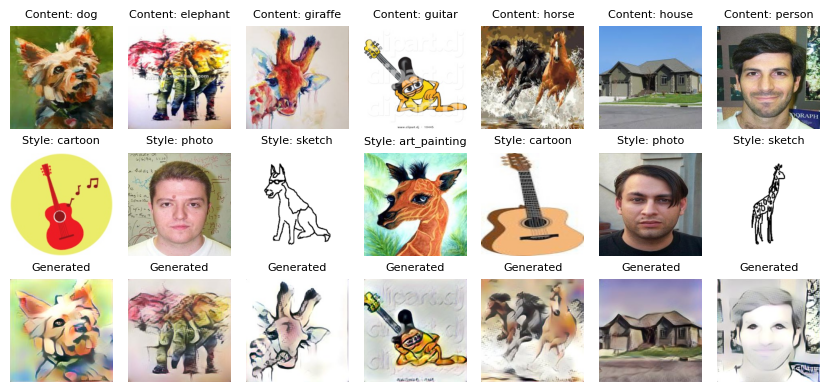

In [ ]:
def parse_generated_image_name(filename):
    parts = filename.rsplit('_', 2)
    content_idx = int(parts[-2])
    style_idx = int(parts[-1].split('.')[0])
    return content_idx, style_idx

def display_image(row, column_axes, dataset, image_dir):
    content_idx, style_idx = parse_generated_image_name(row['filename'])
    content_path = dataset.data_frame.iloc[content_idx]['filepath']
    style_path = dataset.data_frame.iloc[style_idx]['filepath']
    generated_path = os.path.join(image_dir, row['filename'])

    # Load and display images
    content_image = mpimg.imread(content_path)
    style_image = mpimg.imread(style_path)
    generated_image = mpimg.imread(generated_path)

    # Plot images
    column_axes[0].imshow(content_image)
    column_axes[0].set_title(f"Content: {row['classification']}", fontsize=8)
    column_axes[0].axis('off')

    column_axes[1].imshow(style_image)
    column_axes[1].set_title(f"Style: {row['style']}", fontsize=8)
    column_axes[1].axis('off')

    column_axes[2].imshow(generated_image)
    column_axes[2].set_title("Generated", fontsize=8)
    column_axes[2].axis('off')

def showcase_samples_by_labels_and_styles(tsv_path, image_dir, dataset):
    # Load generated images metadata
    df_generated = pd.read_csv(tsv_path, sep='\t', names=['filename', 'style', 'classification'])
    unique_labels = df_generated['classification'].unique()
    unique_styles = df_generated['style'].unique()

    # Determine the number of columns for the subplot
    ncols = min(len(unique_labels), len(df_generated))

    # Setup plot with 3 rows for content, style, generated, and dynamic columns
    fig, axes = plt.subplots(3, ncols, figsize=(1.2 * ncols, 4))

    if ncols == 1:
        axes = np.expand_dims(axes, axis=1)  # Make it iterable in case of a single sample

    col_counter = 0
    style_counter = 1
    for label in unique_labels:
        if col_counter >= ncols:
            break
        samples = df_generated[(df_generated['classification'] == label) & (df_generated['style'] == unique_styles[style_counter%len(unique_styles)])]
        if not samples.empty:
            sample = samples.sample(n=1).iloc[0]
            display_image(sample, axes[:, col_counter], dataset, image_dir)
            col_counter += 1
            style_counter += 1

    plt.tight_layout()
    plt.show()

DERIVED_DS_PATH = os.path.join(pacs_path, "derived-files/")
DERIVED_TSV_PATH = os.path.join(pacs_path, "derived-data.tsv")
showcase_samples_by_labels_and_styles(DERIVED_TSV_PATH, DERIVED_DS_PATH, train_ds)


Now we can train another classifier using the augmented data:

In [ ]:
PART2_SAVE_PATH_2 = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/part2/classify-augmentation.h5"
part2_loss_file_path_2 = "/content/drive/My Drive/Colab Notebooks/comp4211/pa2/part2/part2_aug_loss_records.json"
# [Call your train function here, training on train2_ds]
part2_training_time=0
start = time.time()
#part2_train(model2, train2_ds, loss2, n_epochs=100, save_path=PART2_SAVE_PATH_2, save_interval=5, loss_file_path=part2_loss_file_path_2)
part2_training_time = time.time() - start
print(f"Total training time: {part2_training_time}")


Total training time: 4.1961669921875e-05


part2_aug_bs_16 training time: 4129.839704751968

In [ ]:
epoch_trained = retrieve_epoch_from_file(part2_loss_file_path_2)
print(epoch_trained)

100


In [ ]:
PART2_LOAD_PATH_2 = PART2_SAVE_PATH_2
#part2_train(model2, train2_ds, loss2, n_epochs=100, save_path=PART2_SAVE_PATH_2, load_path=PART2_LOAD_PATH_2, save_interval=5, loss_file_path=part2_loss_file_path_2)


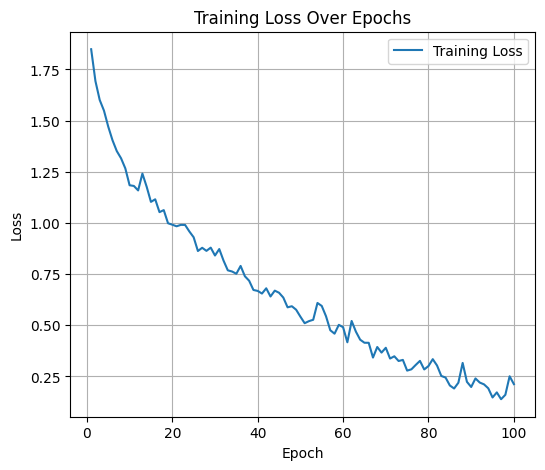

In [ ]:
part2_plot_loss_from_file(part2_loss_file_path_2)

Test the model for any performance changes. After that, feel free to explore on more ways to improve the model!

In [ ]:
train_accuracy_2, train_cm_2, train_all_true_labels_2, train_all_pred_labels_2 = part2_evaluate(PART2_SAVE_PATH_2, train_ds)
test_accuracy_2, test_cm_2, test_all_true_labels_2, test_all_pred_labels_2 = part2_evaluate(PART2_SAVE_PATH_2, test_ds)

In [ ]:
print(f"Train Accuracy: {train_accuracy_2:.4f}")
print(f"Test Accuracy: {test_accuracy_2:.4f}")

Train Accuracy: 0.9344
Test Accuracy: 0.4922


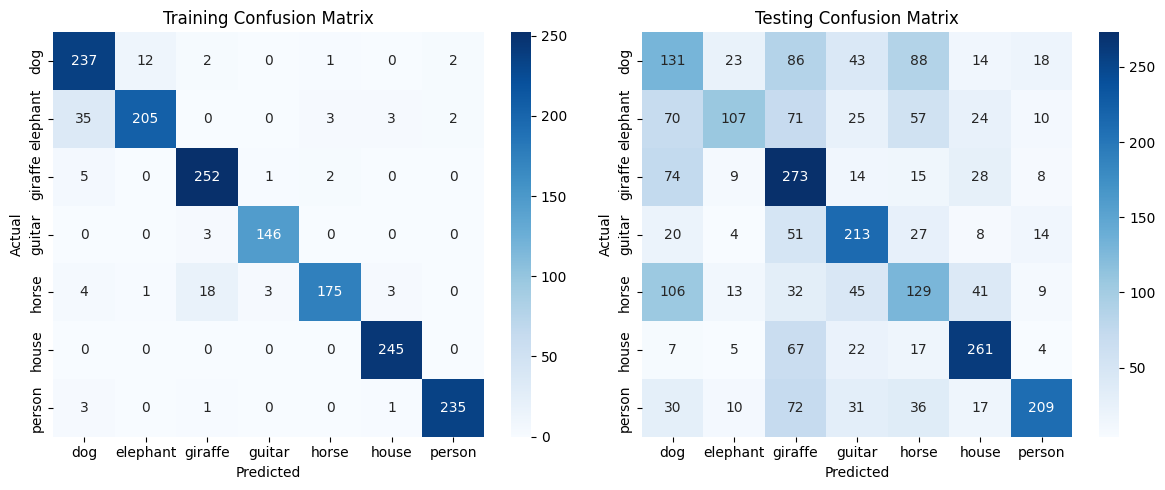

In [ ]:
plot_confusion_matrices(train_cm_2, test_cm_2, train_ds.label_classes.tolist())

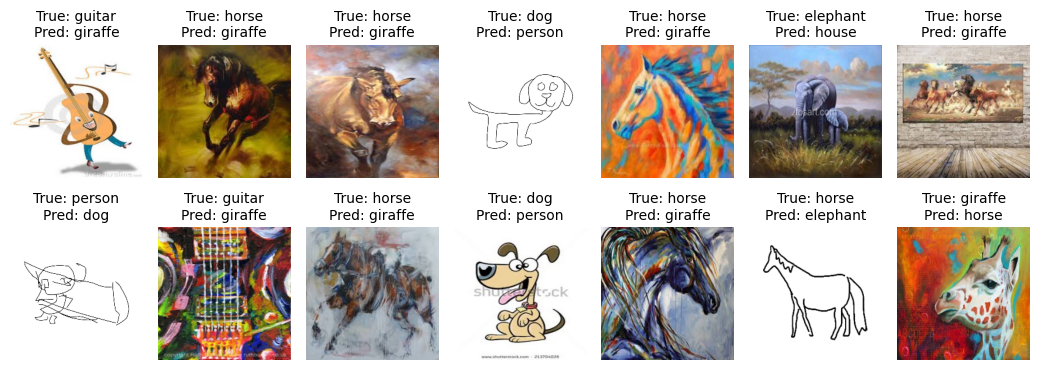

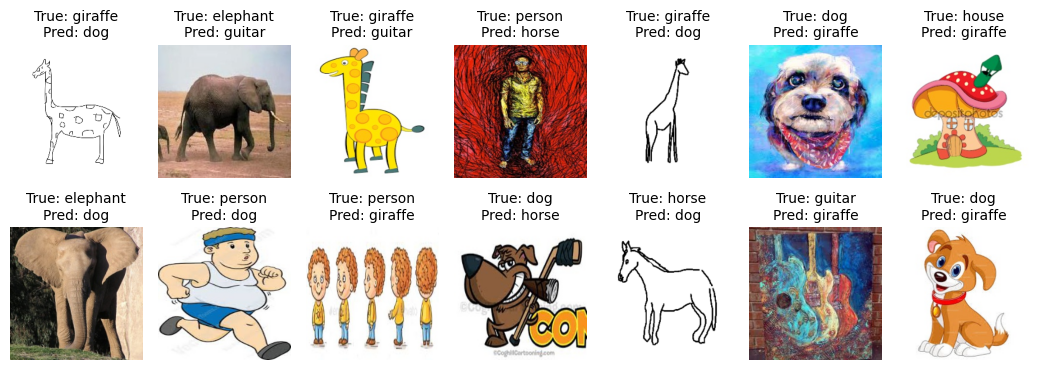

In [ ]:
showcase_mislabeled_images(train_all_true_labels_2, train_all_pred_labels_2, train_ds, num_rows=2)
print()
showcase_mislabeled_images(test_all_true_labels_2, test_all_pred_labels_2, test_ds, num_rows=2)